In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Create structured test data with semantic groups
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

# Assign group labels (0: Animal, 1: Nature, 2: Human)
groups = [0] * 6 + [1] * 6 + [2] * 6

def set_seeds(seed=42):
    """Set random seeds for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set random seeds for reproducibility
set_seeds()

In [9]:
def prepare_data(sentences):
    """Convert sentences to token indices using a simple vocabulary"""
    # Build vocabulary from sentences
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    # Add padding token at index 0
    vocab = {'<PAD>': 0}
    vocab.update({word: idx+1 for idx, word in enumerate(sorted(words))})
    
    # Find max length for padding
    max_len = max(len(sentence.split()) for sentence in sentences)
        
    # Convert sentences to padded token indices
    encoded = []
    for sentence in sentences:
        tokens = [vocab[word.lower()] for word in sentence.split()]
        # Pad with zeros to max_len
        padded = tokens + [0] * (max_len - len(tokens))
        encoded.append(padded)
    
    return vocab, torch.tensor(encoded)  # Convert to tensor here

In [7]:

class BaseEmbeddingModel(nn.Module):
    """Base embedding model using unnormalized dot products"""
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        return summed / lengths

class RegularizedEmbeddingModel(nn.Module):
    """Implementation of the paper's second case (Eq. 2) with separate L2 regularization"""
    def __init__(self, vocab_size, embedding_dim, lambda_reg=0.01):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lambda_reg = lambda_reg
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        averaged = summed / lengths
        
        # Apply L2 regularization separately to embeddings
        if self.training:
            self.reg_loss = self.lambda_reg * (torch.norm(averaged, p=2, dim=1).mean() + 
                                             torch.norm(self.embedding.weight, p=2, dim=1).mean())
        return averaged

class SphericalEmbeddingModel(nn.Module):
    """Embedding model with explicit normalization"""
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        averaged = summed / lengths
        return F.normalize(averaged, p=2, dim=1)

def train_model(model, data_loader, num_epochs, learning_rate, margin=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in data_loader:
            anchor, pos, neg = batch
            
            # Get embeddings
            anchor_emb = model(anchor)
            pos_emb = model(pos)
            neg_emb = model(neg)
            
            # Compute similarities
            pos_sim = (anchor_emb * pos_emb).sum(dim=1)
            neg_sim = (anchor_emb * neg_emb).sum(dim=1)
            
            # Triplet loss
            loss = F.relu(neg_sim - pos_sim + margin).mean()
            
            # Add regularization loss for RegularizedEmbeddingModel
            if hasattr(model, 'reg_loss'):
                loss += model.reg_loss
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss/len(data_loader):.4f}')

def analyze_embeddings(model, data_loader, scaling_factors=[0.1, 1.0, 10.0]):
    """Analyze embedding behavior under different scaling conditions"""
    model.eval()
    results = {}
    
    with torch.no_grad():
        # Get original embeddings
        all_embeddings = []
        for batch in data_loader:
            embeddings = model(batch[0])
            all_embeddings.append(embeddings)
        all_embeddings = torch.cat(all_embeddings, dim=0)
        
        # Store original similarities
        results['original'] = cosine_similarity(all_embeddings)
        
        # Test different scaling factors
        for scale in scaling_factors:
            # Scale first half of dimensions
            scaled_embeddings = all_embeddings.clone()
            d = scaled_embeddings.shape[1]
            scaled_embeddings[:, :d//2] *= scale
            scaled_embeddings[:, d//2:] /= scale
            
            results[f'scale_{scale}'] = cosine_similarity(scaled_embeddings)
            
    return results

class SimilarityMetrics:
    """Compute various similarity metrics"""
    @staticmethod
    def compute_cluster_metrics(similarities, labels):
        n_clusters = len(set(labels))
        metrics = {}
        
        # Within-cluster similarities
        for i in range(n_clusters):
            mask = np.array(labels) == i
            cluster_sim = similarities[mask][:, mask]
            np.fill_diagonal(cluster_sim, 0)
            metrics[f'cluster_{i}_internal'] = cluster_sim.mean()
            
        # Between-cluster similarities
        for i in range(n_clusters):
            for j in range(i+1, n_clusters):
                mask_i = np.array(labels) == i
                mask_j = np.array(labels) == j
                between_sim = similarities[mask_i][:, mask_j]
                metrics[f'cluster_{i}_{j}_external'] = between_sim.mean()
                
        return metrics

def visualize_results(results, labels, title_prefix=""):
    """Visualize similarity matrices and their differences"""
    n_plots = len(results)
    fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))
    
    for ax, (name, sim_matrix) in zip(axes, results.items()):
        sns.heatmap(sim_matrix, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f'{title_prefix}\n{name}')
    
    plt.tight_layout()
    return fig

# Usage example:
class TripletDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = torch.tensor(sentences)  # Convert to tensor here
        self.labels = labels
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        # Get anchor
        anchor = self.sentences[idx]
        anchor_label = self.labels[idx]
        
        # Sample positive (same label)
        pos_indices = [i for i, l in enumerate(self.labels) 
                      if l == anchor_label and i != idx]
        pos_idx = np.random.choice(pos_indices)
        positive = self.sentences[pos_idx]
        
        # Sample negative (different label)
        neg_indices = [i for i, l in enumerate(self.labels) 
                      if l != anchor_label]
        neg_idx = np.random.choice(neg_indices)
        negative = self.sentences[neg_idx]
        
        return anchor, positive, negative

In [10]:
# Setup data
vocab, encoded_sentences = prepare_data(sentences)
dataset = TripletDataset(encoded_sentences, groups)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)  # Reduced batch size

# Initialize models with correct vocab size
vocab_size = len(vocab)  # This will now include the padding token
base_model = BaseEmbeddingModel(vocab_size, 50)
reg_model = RegularizedEmbeddingModel(vocab_size, 50)
spherical_model = SphericalEmbeddingModel(vocab_size, 50)

# Train models
for model in [base_model, reg_model, spherical_model]:
    train_model(model, data_loader, num_epochs=100, learning_rate=0.001)

# Analyze results
base_results = analyze_embeddings(base_model, data_loader)
reg_results = analyze_embeddings(reg_model, data_loader)
spherical_results = analyze_embeddings(spherical_model, data_loader)

/var/folders/py/19s8w1_s0_g5bw1c_0qmm1s80000gn/T/ipykernel_49456/587082552.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sentences = torch.tensor(sentences)  # Convert to tensor here


Epoch 10, Loss: 0.7161
Epoch 20, Loss: 1.4345
Epoch 30, Loss: 0.2450
Epoch 40, Loss: 1.4549
Epoch 50, Loss: 1.1403
Epoch 60, Loss: 0.7825
Epoch 70, Loss: 0.3024
Epoch 80, Loss: 0.1929
Epoch 90, Loss: 0.5576
Epoch 100, Loss: 0.4128
Epoch 10, Loss: 1.1399
Epoch 20, Loss: 0.8516
Epoch 30, Loss: 1.0840
Epoch 40, Loss: 0.3093
Epoch 50, Loss: 0.5667
Epoch 60, Loss: 0.3682
Epoch 70, Loss: 0.4321
Epoch 80, Loss: 0.7236
Epoch 90, Loss: 0.3261
Epoch 100, Loss: 0.4843
Epoch 10, Loss: 0.4297
Epoch 20, Loss: 0.4521
Epoch 30, Loss: 0.3991
Epoch 40, Loss: 0.3533
Epoch 50, Loss: 0.4111
Epoch 60, Loss: 0.4664
Epoch 70, Loss: 0.3918
Epoch 80, Loss: 0.3451
Epoch 90, Loss: 0.3542
Epoch 100, Loss: 0.2750


In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def create_visualization_suite(models, data_loader, groups, scaling_factors=[0.1, 1.0, 10.0]):
    """Create comprehensive visualization suite for embedding analysis"""
    
    def get_embeddings(model, data):
        model.eval()
        with torch.no_grad():
            embeddings = model(data)
            return embeddings.numpy()
    
    # Get all data in one batch
    all_data = next(iter(DataLoader(data_loader.dataset, batch_size=len(data_loader.dataset))))[0]
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, len(models))
    
    # Color map for different groups
    colors = ['#ff7f0e', '#1f77b4', '#2ca02c']
    group_names = ['Animal', 'Nature', 'Human']
    
    # Plot for each model
    for model_idx, (model_name, model) in enumerate(models.items()):
        embeddings = get_embeddings(model, all_data)
        
        # 1. Original Space Visualization (PCA)
        ax = fig.add_subplot(gs[0, model_idx])
        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings)
        
        for group_idx in range(3):
            mask = np.array(groups) == group_idx
            ax.scatter(reduced_embeddings[mask, 0], reduced_embeddings[mask, 1], 
                      c=[colors[group_idx]], label=group_names[group_idx], alpha=0.7)
        
        ax.set_title(f'{model_name}\nPCA Visualization')
        if model_idx == 0:
            ax.set_ylabel('Original Embeddings')
        ax.legend()
        
        # 2. Similarity Matrix
        ax = fig.add_subplot(gs[1, model_idx])
        similarities = np.dot(embeddings, embeddings.T)
        if model_name != "Regularized Model":  # Normalize for cosine similarity
            norms = np.linalg.norm(embeddings, axis=1)
            similarities = similarities / np.outer(norms, norms)
            
        sns.heatmap(similarities, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f'Similarity Matrix')
        if model_idx == 0:
            ax.set_ylabel('Original Similarities')
            
        # 3. Scaled Similarity Matrix
        ax = fig.add_subplot(gs[2, model_idx])
        # Apply scaling to first half of dimensions
        scaled_embeddings = embeddings.copy()
        d = scaled_embeddings.shape[1]
        scaled_embeddings[:, :d//2] *= scaling_factors[-1]
        scaled_embeddings[:, d//2:] /= scaling_factors[-1]
        
        scaled_similarities = np.dot(scaled_embeddings, scaled_embeddings.T)
        if model_name != "Regularized Model":  # Normalize for cosine similarity
            scaled_norms = np.linalg.norm(scaled_embeddings, axis=1)
            scaled_similarities = scaled_similarities / np.outer(scaled_norms, scaled_norms)
            
        sns.heatmap(scaled_similarities, ax=ax, cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_title(f'Scaled Similarity Matrix\n(scale={scaling_factors[-1]})')
        if model_idx == 0:
            ax.set_ylabel('Scaled Similarities')
    
    plt.tight_layout()
    return fig

def plot_similarity_distributions(models, data_loader, groups):
    """Plot distribution of similarities within and between groups"""
    fig, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
    
    def get_embeddings(model, data):
        model.eval()
        with torch.no_grad():
            embeddings = model(data)
            return embeddings.numpy()
    
    # Get all data
    all_data = next(iter(DataLoader(data_loader.dataset, batch_size=len(data_loader.dataset))))[0]
    
    for idx, (model_name, model) in enumerate(models.items()):
        embeddings = get_embeddings(model, all_data)
        
        # Calculate similarities
        similarities = np.dot(embeddings, embeddings.T)
        if model_name != "Regularized Model":
            norms = np.linalg.norm(embeddings, axis=1)
            similarities = similarities / np.outer(norms, norms)
        
        # Collect within-group and between-group similarities
        within_sims = []
        between_sims = []
        
        for i in range(len(similarities)):
            for j in range(i+1, len(similarities)):
                if groups[i] == groups[j]:
                    within_sims.append(similarities[i, j])
                else:
                    between_sims.append(similarities[i, j])
        
        # Plot distributions
        ax = axes[idx] if len(models) > 1 else axes
        sns.kdeplot(data=within_sims, ax=ax, label='Within-group', color='blue')
        sns.kdeplot(data=between_sims, ax=ax, label='Between-group', color='red')
        ax.set_title(f'{model_name}\nSimilarity Distributions')
        ax.set_xlabel('Similarity')
        ax.set_ylabel('Density')
        ax.legend()
    
    plt.tight_layout()
    return fig

def create_group_metrics_table(models, data_loader, groups):
    """Create a table of metrics for each group and model"""
    metrics = {}
    
    def get_embeddings(model, data):
        model.eval()
        with torch.no_grad():
            embeddings = model(data)
            return embeddings.numpy()
    
    # Get all data
    all_data = next(iter(DataLoader(data_loader.dataset, batch_size=len(data_loader.dataset))))[0]
    
    for model_name, model in models.items():
        embeddings = get_embeddings(model, all_data)
        
        # Calculate similarities
        similarities = np.dot(embeddings, embeddings.T)
        if model_name != "Regularized Model":
            norms = np.linalg.norm(embeddings, axis=1)
            similarities = similarities / np.outer(norms, norms)
        
        # Calculate metrics for each group
        model_metrics = {}
        for group_idx in range(3):
            mask = np.array(groups) == group_idx
            
            # Within-group similarity
            group_sim = similarities[mask][:, mask]
            np.fill_diagonal(group_sim, 0)  # Exclude self-similarity
            model_metrics[f'Group {group_idx} Internal'] = group_sim.mean()
            
            # Between-group similarity (with next group)
            next_group = (group_idx + 1) % 3
            next_mask = np.array(groups) == next_group
            between_sim = similarities[mask][:, next_mask]
            model_metrics[f'Group {group_idx}-{next_group} External'] = between_sim.mean()
        
        metrics[model_name] = model_metrics
    
    return metrics

# Example usage:
def run_visualization_analysis(base_model, reg_model, spherical_model, data_loader, groups):
    models = {
        'Base Model': base_model,
        'Regularized Model': reg_model,
        'Spherical Model': spherical_model
    }
    
    # Create main visualization suite
    fig1 = create_visualization_suite(models, data_loader, groups)
    plt.figure(fig1.number)
    plt.savefig('embedding_analysis.png', dpi=300, bbox_inches='tight')
    
    # Create similarity distribution plots
    fig2 = plot_similarity_distributions(models, data_loader, groups)
    plt.figure(fig2.number)
    plt.savefig('similarity_distributions.png', dpi=300, bbox_inches='tight')
    
    # Get metrics
    metrics = create_group_metrics_table(models, data_loader, groups)
    
    # Print metrics
    print("\nGroup Metrics:")
    for model_name, model_metrics in metrics.items():
        print(f"\n{model_name}:")
        for metric_name, value in model_metrics.items():
            print(f"{metric_name}: {value:.3f}")
    
    return fig1, fig2, metrics


Group Metrics:

Base Model:
Group 0 Internal: 0.429
Group 0-1 External: 0.192
Group 1 Internal: 0.214
Group 1-2 External: 0.216
Group 2 Internal: 0.350
Group 2-0 External: 0.339

Regularized Model:
Group 0 Internal: 6.818
Group 0-1 External: 3.511
Group 1 Internal: 3.788
Group 1-2 External: 3.394
Group 2 Internal: 5.178
Group 2-0 External: 5.447

Spherical Model:
Group 0 Internal: 0.443
Group 0-1 External: 0.201
Group 1 Internal: 0.251
Group 1-2 External: 0.198
Group 2 Internal: 0.424
Group 2-0 External: 0.361


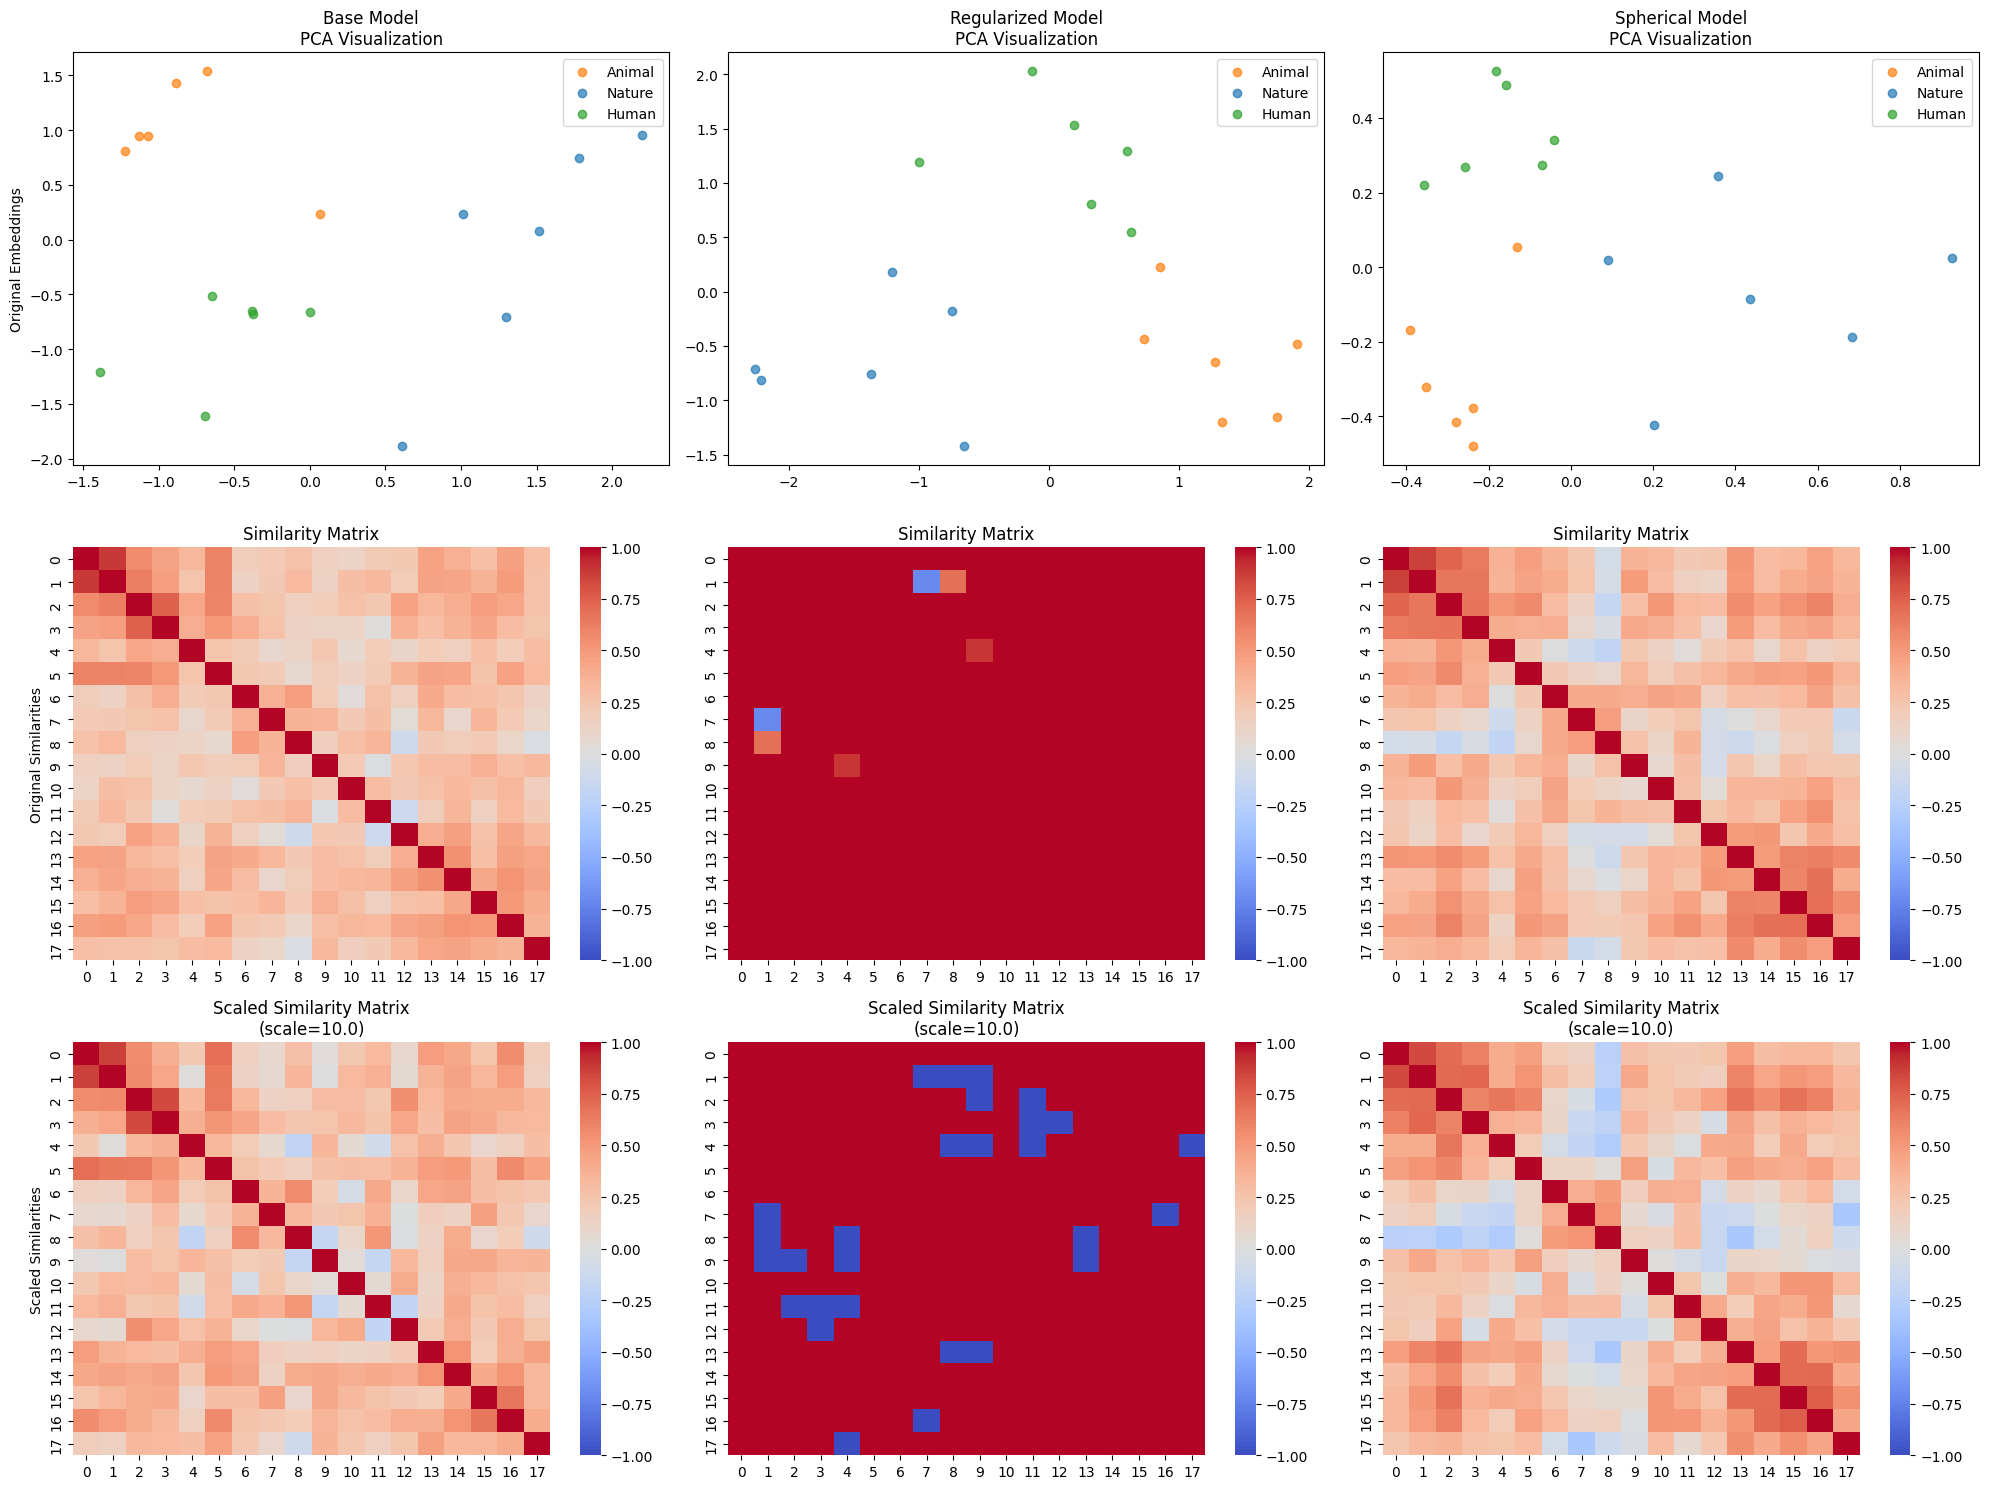

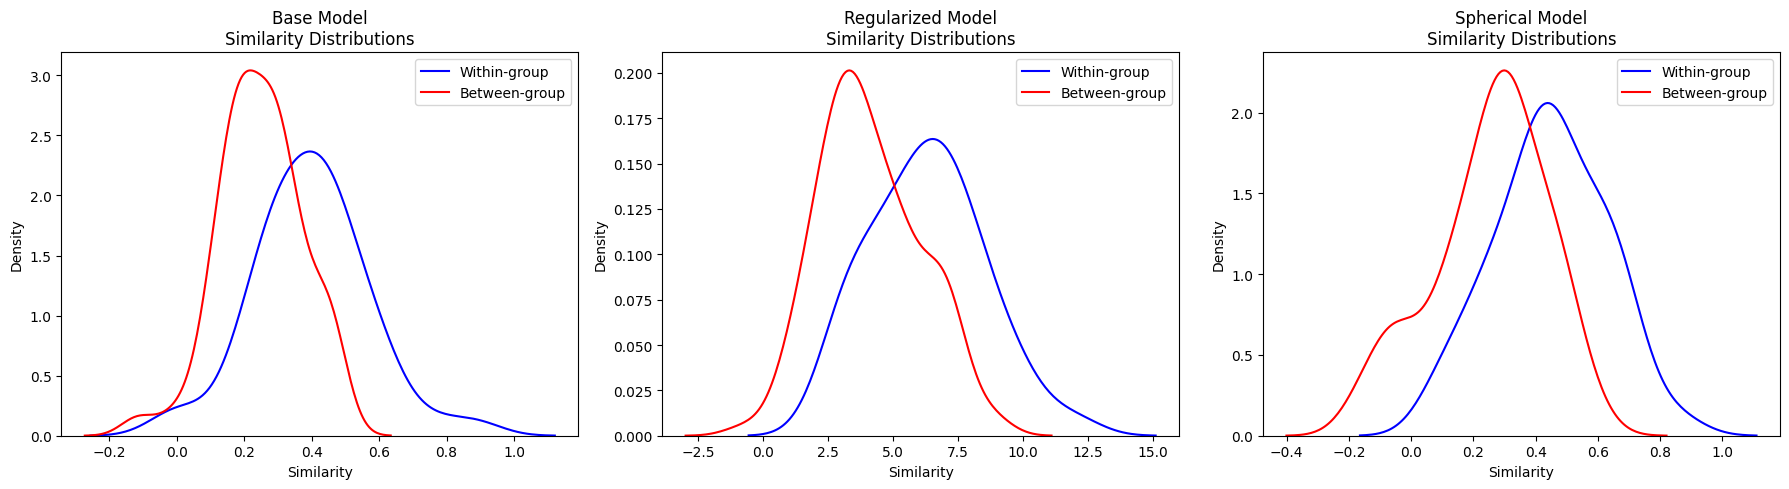

In [16]:
# After training your models
fig1, fig2, metrics = run_visualization_analysis(
    base_model, 
    reg_model, 
    spherical_model, 
    data_loader, 
    groups
)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class ComparisonAnalysis:
    """Compare dot products vs cosine similarities across models"""
    def __init__(self, base_model, reg_model, spherical_model, data_loader):
        self.models = {
            'Base': base_model,
            'Regularized': reg_model,
            'Spherical': spherical_model
        }
        self.data_loader = data_loader

    def get_embeddings(self, model):
        model.eval()
        with torch.no_grad():
            batch = next(iter(DataLoader(self.data_loader.dataset, 
                                      batch_size=len(self.data_loader.dataset))))[0]
            return model(batch).numpy()

    def compute_similarities(self, embeddings):
        """Compute both dot product and cosine similarities"""
        dot_product = np.dot(embeddings, embeddings.T)
        norms = np.linalg.norm(embeddings, axis=1)
        cosine_sim = dot_product / np.outer(norms, norms)
        return dot_product, cosine_sim

    def analyze_group_separation(self, similarities, groups):
        """Compute metrics for group separation"""
        metrics = {}
        for sim_type, sim_matrix in similarities.items():
            within_group = []
            between_group = []
            
            for i in range(len(sim_matrix)):
                for j in range(i + 1, len(sim_matrix)):
                    if groups[i] == groups[j]:
                        within_group.append(sim_matrix[i, j])
                    else:
                        between_group.append(sim_matrix[i, j])
            
            metrics[sim_type] = {
                'within_mean': np.mean(within_group),
                'between_mean': np.mean(between_group),
                'separation': np.mean(within_group) - np.mean(between_group)
            }
        return metrics

    def visualize_comparison(self, groups):
        fig, axes = plt.subplots(2, len(self.models), figsize=(15, 10))
        
        all_metrics = {}
        
        for idx, (name, model) in enumerate(self.models.items()):
            embeddings = self.get_embeddings(model)
            dot_prod, cosine_sim = self.compute_similarities(embeddings)
            
            # Plot dot products
            sns.heatmap(dot_prod, ax=axes[0, idx], cmap='coolwarm', 
                       center=0, vmin=dot_prod.min(), vmax=dot_prod.max())
            axes[0, idx].set_title(f'{name} Model\nDot Products')
            
            # Plot cosine similarities
            sns.heatmap(cosine_sim, ax=axes[1, idx], cmap='coolwarm',
                       vmin=-1, vmax=1)
            axes[1, idx].set_title('Cosine Similarities')
            
            # Compute metrics
            all_metrics[name] = self.analyze_group_separation(
                {'dot_product': dot_prod, 'cosine': cosine_sim}, 
                groups
            )
        
        plt.tight_layout()
        return fig, all_metrics

    def print_metrics_comparison(self, metrics):
        print("\nModel Comparison Metrics:")
        print("-" * 50)
        for model_name, model_metrics in metrics.items():
            print(f"\n{model_name} Model:")
            print("  Dot Product:")
            print(f"    Within-group mean:  {model_metrics['dot_product']['within_mean']:.3f}")
            print(f"    Between-group mean: {model_metrics['dot_product']['between_mean']:.3f}")
            print(f"    Separation:         {model_metrics['dot_product']['separation']:.3f}")
            print("  Cosine Similarity:")
            print(f"    Within-group mean:  {model_metrics['cosine']['within_mean']:.3f}")
            print(f"    Between-group mean: {model_metrics['cosine']['between_mean']:.3f}")
            print(f"    Separation:         {model_metrics['cosine']['separation']:.3f}")

# Usage example
def run_comparison_analysis(base_model, reg_model, spherical_model, data_loader, groups):
    analyzer = ComparisonAnalysis(base_model, reg_model, spherical_model, data_loader)
    fig, metrics = analyzer.visualize_comparison(groups)
    analyzer.print_metrics_comparison(metrics)
    return fig, metrics


Model Comparison Metrics:
--------------------------------------------------

Base Model:
  Dot Product:
    Within-group mean:  4.473
    Between-group mean: 2.845
    Separation:         1.627
  Cosine Similarity:
    Within-group mean:  0.397
    Between-group mean: 0.249
    Separation:         0.148

Regularized Model:
  Dot Product:
    Within-group mean:  6.313
    Between-group mean: 4.118
    Separation:         2.196
  Cosine Similarity:
    Within-group mean:  0.511
    Between-group mean: 0.336
    Separation:         0.175

Spherical Model:
  Dot Product:
    Within-group mean:  0.447
    Between-group mean: 0.253
    Separation:         0.194
  Cosine Similarity:
    Within-group mean:  0.447
    Between-group mean: 0.253
    Separation:         0.194


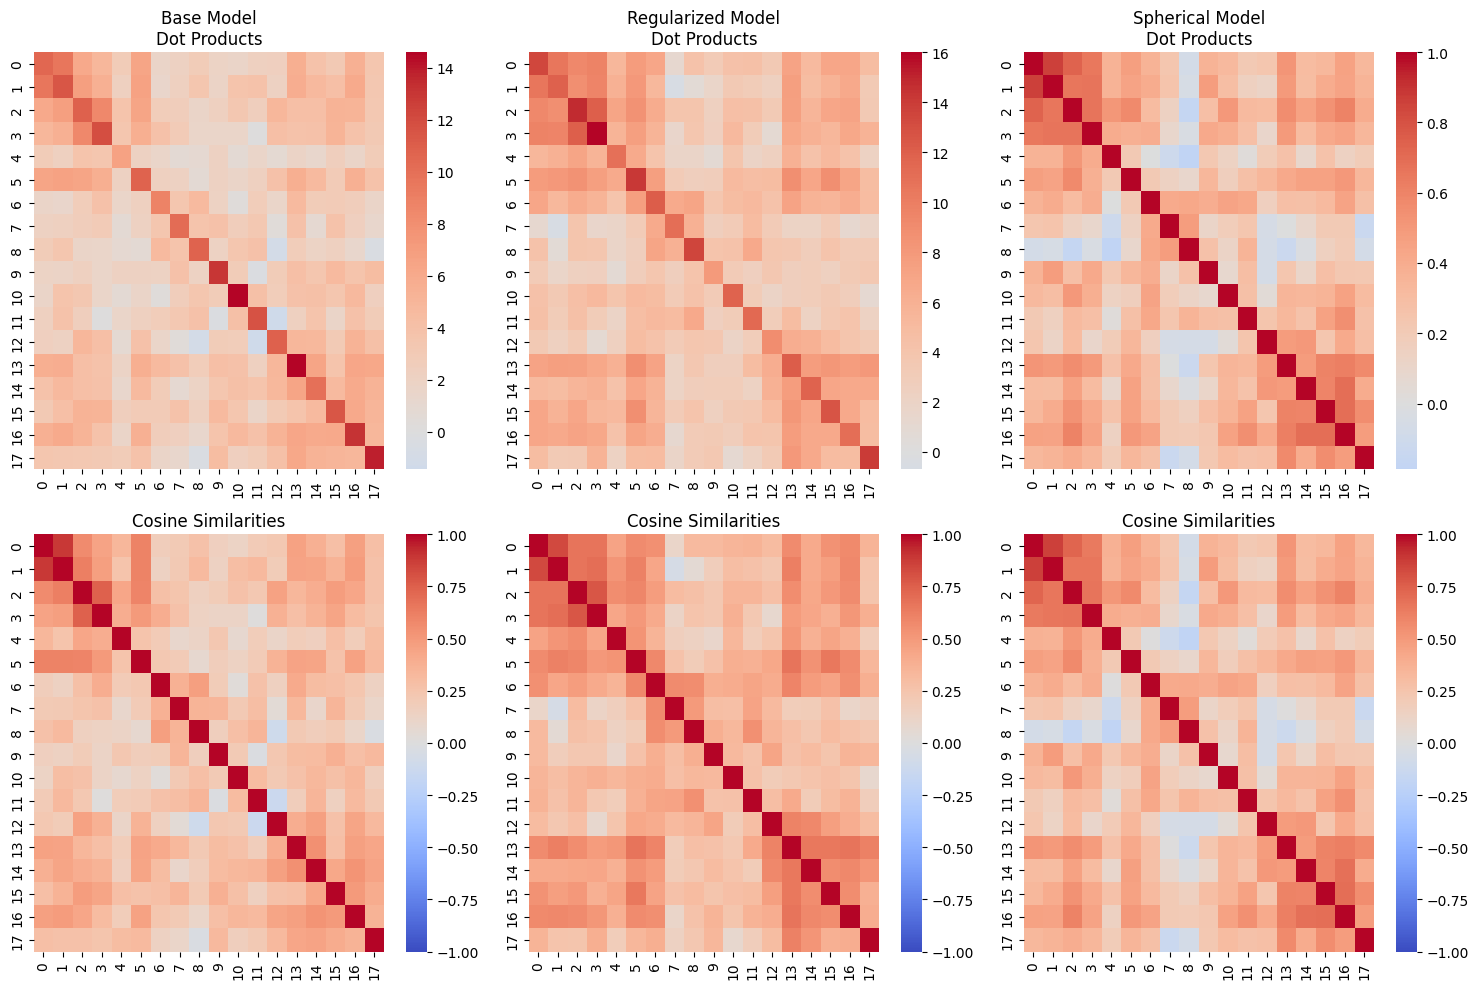

In [18]:
fig, metrics = run_comparison_analysis(base_model, reg_model, spherical_model, data_loader, groups)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse your existing sentence data and groups
sentences = [
    # Animal group
    "The cat chases the mouse",
    "The dog chases the cat",
    "The lion hunts the gazelle", 
    "The wolf hunts the deer",
    "The tiger stalks its prey",
    "The fox catches the rabbit",
    # Nature group
    "The tree sways in the wind",
    "The flower blooms in spring", 
    "The grass grows in sunlight",
    "The river flows downstream",
    "The leaves rustle gently",
    "The rain falls softly",
    # Human group
    "The teacher writes on board",
    "The student reads the book",
    "The worker builds the house",
    "The chef cooks the meal", 
    "The artist paints the canvas",
    "The doctor helps patients"
]

groups = [0] * 6 + [1] * 6 + [2] * 6

# Data preparation function
def prepare_data(sentences):
    words = set()
    for sentence in sentences:
        words.update(sentence.lower().split())
    vocab = {word: idx+1 for idx, word in enumerate(sorted(words))}
    
    encoded = []
    for sentence in sentences:
        encoded.append([vocab[word.lower()] for word in sentence.split()])
    
    return vocab, encoded

# Model definitions with slight modifications
class BaseModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        return summed / lengths

class RegularizedModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, lambda_reg=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lambda_reg = lambda_reg
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        averaged = summed / lengths
        
        if self.training:
            self.reg_loss = self.lambda_reg * (
                torch.norm(averaged, p=2, dim=1).mean() + 
                torch.norm(self.embedding.weight, p=2, dim=1).mean()
            )
        return averaged

class SphericalModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, x):
        embedded = self.embedding(x)
        mask = (x != 0).float().unsqueeze(-1)
        summed = (embedded * mask).sum(dim=1)
        lengths = mask.sum(dim=1).clamp(min=1)
        averaged = summed / lengths
        return F.normalize(averaged, p=2, dim=1)

# Training function with triplet loss
def train_model(model, data_loader, epochs=100, lr=0.001, margin=0.5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in data_loader:
            anchor, pos, neg = batch
            
            # Get embeddings
            anchor_emb = model(anchor)
            pos_emb = model(pos)
            neg_emb = model(neg)
            
            # Compute similarities
            pos_sim = (anchor_emb * pos_emb).sum(dim=1)
            neg_sim = (anchor_emb * neg_emb).sum(dim=1)
            
            # Triplet loss
            loss = F.relu(neg_sim - pos_sim + margin).mean()
            
            # Add regularization loss if applicable
            if hasattr(model, 'reg_loss'):
                loss += model.reg_loss
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}, Loss: {total_loss/len(data_loader):.4f}')

# Dataset class
class TripletDataset(Dataset):
    def __init__(self, encoded_sentences, labels):
        """
        Args:
            encoded_sentences: torch.Tensor of shape (num_sentences, max_len)
            labels: list of labels
        """
        self.sentences = encoded_sentences  # Already a tensor from prepare_data
        self.labels = labels
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        # Get anchor
        anchor = self.sentences[idx]
        anchor_label = self.labels[idx]
        
        # Sample positive (same label)
        pos_indices = [i for i, l in enumerate(self.labels) 
                      if l == anchor_label and i != idx]
        pos_idx = np.random.choice(pos_indices)
        positive = self.sentences[pos_idx]
        
        # Sample negative (different label)
        neg_indices = [i for i, l in enumerate(self.labels) 
                      if l != anchor_label]
        neg_idx = np.random.choice(neg_indices)
        negative = self.sentences[neg_idx]
        
        return anchor, positive, negative

# Main execution
def run_full_comparison():
    # Prepare data
    vocab, encoded_sentences = prepare_data(sentences)
    dataset = TripletDataset(encoded_sentences, groups)
    data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

    # Initialize models
    vocab_size = len(vocab) + 1  # +1 for padding
    embedding_dim = 50
    
    base_model = BaseModel(vocab_size, embedding_dim)
    reg_model = RegularizedModel(vocab_size, embedding_dim)
    spherical_model = SphericalModel(vocab_size, embedding_dim)

    # Train models
    print("Training Base Model...")
    train_model(base_model, data_loader)
    
    print("\nTraining Regularized Model...")
    train_model(reg_model, data_loader)
    
    print("\nTraining Spherical Model...")
    train_model(spherical_model, data_loader)

    # Run comparison analysis
    analyzer = ComparisonAnalysis(base_model, reg_model, spherical_model, data_loader)
    fig, metrics = analyzer.visualize_comparison(groups)
    analyzer.print_metrics_comparison(metrics)
    
    return fig, metrics, (base_model, reg_model, spherical_model)

# Run the analysis
fig, metrics, models = run_full_comparison()
plt.show()

Training Base Model...


RuntimeError: stack expects each tensor to be equal size, but got [5] at entry 0 and [6] at entry 1